In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import glob

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Dropout
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, UpSampling2D, LeakyReLU
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras.layers.merge import concatenate
from keras.models import Sequential
from keras.callbacks import TensorBoard, ModelCheckpoint
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
import matplotlib.image as mpimg
from matplotlib import cm
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas


Using TensorFlow backend.


In [2]:
scaler = MinMaxScaler()

latent_dim=64
batch_size=192
patience = 10
epochs=100
plen = 64
save_name = '..'
save_path = '..'
img_rows, img_cols, img_chns = 64, 64, 1
original_img_size=(img_rows, img_cols, img_chns)
callbacks = [EarlyStopping(monitor='val_loss', patience=patience, verbose=1)]

adadelta=optimizers.Adadelta()


x = Input(shape=original_img_size)
cond = Input(shape=(6,))

In [3]:
def conv_layer(x,filter_,kernel,stride):
    conv = Conv2D(filter_,kernel_size=kernel, strides = stride,padding='same', activation=None)(x)
    bn = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)(conv)
    act = LeakyReLU(alpha=0.3)(bn)
    drop = Dropout(0.2)(act)
    return(drop)

def deconv_layer(filter_,kernel,stride):
    deconv = Conv2D(filter_,kernel_size=kernel,strides = stride,padding='same', activation=None)
    bn = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)
    act = LeakyReLU(alpha=0.3)
    drop = Dropout(0.2)
    ups = UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest')
    return deconv, bn, act, drop, ups

def deconv_output(filter_,kernel,stride):
    deconv = Conv2D(filter_,kernel_size=kernel,strides = stride,padding='same', activation=None)
    bn = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)
    act = LeakyReLU(alpha=0.3)
    drop = Dropout(0.2)

    ups = UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest')
    deconv_output = Conv2D(1,kernel_size=kernel,strides = stride,padding='same', activation='sigmoid')
    return deconv,bn,act,drop,ups,deconv_output

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_var) * epsilon

def create_predictor_linear(latent_dim, output_dim=6):
    '''
    Creates a regressor that estimates digit values 
    from latent variables.
    '''
    predictor_input = layers.Input(shape=(latent_dim,))
    
    #x_ = layers.Dense(latent_dim, activation='relu')(predictor_input)
    x_ = layers.Dense(20, activation='relu')(predictor_input)

    x_ = layers.Dense(20, activation='relu')(x_)
    x_ = layers.Dense(20, activation='relu')(x_)
    x_ = layers.Dense(6, activation='relu')(x_)

    x_ = layers.Dense(output_dim, activation='linear')(x_)

    return Model(predictor_input, x_, name='predictor')

def plot_train_history_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['model_2_loss'])
    plt.plot(history.history['predictor_loss'])
    plt.plot(history.history['val_predictor_loss'])
    plt.plot(history.history['val_model_2_loss'])
    
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss','model_2_loss','val_model_2_loss','predictor_loss','val_predictor_loss'], loc='upper right')
    plt.show()


In [29]:
def gSZD_imscatter(x, y,img, ax,zoom):
    images = []
    for i in range(len(x)):
        x0, y0 = x[i], y[i]

        image = img[i].reshape(plen, plen)

        image = OffsetImage(image, zoom=zoom)
        ab = AnnotationBbox(image, (x0, y0), xycoords='data', frameon=False)
        images.append(ax.add_artist(ab))
    
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    
def SZD_imscatter(x, y,ax,image_data,zoom):
    images = []
    for i in range(len(en_mean_test[:4000,:])):
        x0, y0 = x[i], y[i]

        img=image_data[i,:,:,0]

        image = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(image, (x0, y0), xycoords='data', frameon=False)
        images.append(ax.add_artist(ab))
    
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

def create_randuni_process_vector(num_samples, set_zero,addition):
    process_vector = np.concatenate([
        np.reshape(np.random.uniform(0,800,num_samples),(num_samples,1)),
        np.reshape(np.random.uniform(0,70,num_samples),(num_samples,1)),
        np.reshape(np.random.uniform(0,10,num_samples),(num_samples,1)),
        np.reshape(np.random.uniform(100,1000,num_samples),(num_samples,1)),
        np.reshape(np.random.uniform(0,200,num_samples),(num_samples,1)),
        np.reshape(np.random.uniform(0.5,1,num_samples),(num_samples,1))
    ],axis=1)
    process_vector = np.reshape(process_vector,(num_samples,6))
    process_vector[:,set_zero]=0
    process_vector[:,:]=process_vector[:,:]+addition
    process_vector = scaler.transform(process_vector)

    return process_vector

Enoder model

In [4]:

conv_1=conv_layer(x,32,(4,4),(2,2))
conv_2=conv_layer(conv_1,64,(4,4),(2,2))
conv_3=conv_layer(conv_2,128,(4,4),(2,2))
conv_4=conv_layer(conv_3,128,(4,4),(2,2))
conv_5=conv_layer(conv_4,128,(4,4),(2,2))
#conv_6=conv_layer(conv_5,64,(4,4),(2,2))
flat = Flatten()(conv_5)


z_mean = Dense(latent_dim)(flat)
z_log_var = Dense(latent_dim)(flat)
#z_cond = concatenate([z_mean, cond])
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model(x, [z_mean,z_log_var])

Decoder layers

In [6]:
interm_decoder=Dense(512,activation='relu')
deconv_1, bn_1, act_1,drop_1, ups_1 = deconv_layer(128,(3,3),(1,1))
deconv_2, bn_2, act_2,drop_2, ups_2 = deconv_layer(128,(3,3),(1,1))
deconv_3, bn_3, act_3,drop_3, ups_3 = deconv_layer(128,(3,3),(1,1))
deconv_4, bn_4, act_4,drop_4, ups_4 = deconv_layer(64,(3,3),(1,1))
deconv_5, bn_5, act_5,drop_5, ups_5, deconv_output_5 = deconv_output(32,(3,3),(1,1))


Decoder model

In [7]:
generator_input = Input(shape=(latent_dim,))
interm_decoder_=interm_decoder(generator_input)
output_shape=(batch_size,2,2,128)
decoder_reshape=Reshape(output_shape[1:])(interm_decoder_)
deconv_1_ = deconv_1(decoder_reshape)
bn_1_ = bn_1(deconv_1_)
act_1_ = act_1(bn_1_)
drop_1_=drop_1(act_1_)
ups_1_ = ups_1(drop_1_)
deconv_2_ = deconv_2(ups_1_)
bn_2_ = bn_2(deconv_2_)
act_2_ = act_2(bn_2_)
drop_2_=drop_2(act_2_)
ups_2_ = ups_2(drop_2_)
deconv_3_ = deconv_3(ups_2_)
bn_3_ = bn_3(deconv_3_)
act_3_ = act_3(bn_3_)
drop_3_=drop_3(act_3_)
ups_3_ = ups_3(drop_3_)
deconv_4_ = deconv_4(ups_3_)
bn_4_ = bn_4(deconv_4_)
act_4_ = act_4(bn_4_)
drop_4_=drop_4(act_4_)
ups_4_ = ups_4(drop_4_)
deconv_5_ = deconv_5(ups_4_)
bn_5_ = bn_5(deconv_5_)
act_5_ = act_5(bn_5_)
drop_5_=drop_5(act_5_)
ups_5_ = ups_5(drop_5_)
deconv_output_5_=deconv_output_5(ups_5_)

decoder = Model(generator_input,deconv_output_5_)

In [8]:
predictor = create_predictor_linear(latent_dim)

t_decoded = decoder(z)
t_predicted = predictor(z)

model = Model(x, [t_decoded,t_predicted])

decoder.summary()

Define loss function

In [9]:
def vae_loss(x,t_decoded):
    xent_loss = K.sum(K.binary_crossentropy(
            K.batch_flatten(x),
            K.batch_flatten(t_decoded)),axis=-1)
    kl_loss = - .5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vaeloss = K.mean(xent_loss + kl_loss)
    return vaeloss

Compile model

In [10]:
model.compile(optimizer=adadelta, 
                  loss=[vae_loss, 'mean_squared_error'],
                  loss_weights=[1.0, 10000.00])

model.summary()

Load data set

In [11]:
DATA_PATH = ".."
IMAGE_PATH = '..'
IMAGE_SUBPATH=".."

In [12]:
df=pd.read_csv(os.path.join(DATA_PATH,"...CSV"),sep=",")

In [13]:
df.head()

file name  sample id  position  temperature [C]  \
0  0001208_200-Pos1-50kx.jpg       1208         1              200   
1  0001208_200-Pos2-50kx.jpg       1208         2              200   
2  0001208_200-Pos3-50kx.jpg       1208         3              200   
3  0001208_200-Pos4-50kx.jpg       1208         4              200   
4  0001208_200-Pos5-50kx.jpg       1208         5              200   

   Al-concentration [at.%]  O-concentration [at.%]  ionization degree [a.u.]  \
0                    54.85                      10                       0.5   
1                    49.36                      10                       0.5   
2                    43.86                      10                       0.5   
3                    38.38                      10                       0.5   
4                    32.90                      10                       0.5   

   average ion energy [eV]  pressure [Pa]         label  
0                  7.14380            0.5  fine grained  
1                  6.69893            0.5  fine grained  
2                  6.31924            0.5  fine grained  
3                  6.13510            0.5  fine grained  
4                  6.43797            0.5  fine grained

In [14]:
df = df.sample(frac=1).reset_index(drop=True)

In [15]:
df.columns

Index(['file name', 'sample id', 'position', 'temperature [C]',
       'Al-concentration [at.%]', 'O-concentration [at.%]',
       'ionization degree [a.u.]', 'average ion energy [eV]', 'pressure [Pa]',
       'label'],
      dtype='object')

In [16]:
Y_COLUMNS=['temperature [C]','Al-concentration [at.%]', 'O-concentration [at.%]', 'ionization degree [a.u.]','average ion energy [eV]','pressure [Pa]']

In [17]:
BOX_SIZE=128

BATCH_SIZE=16
CROP_PER_IMAGE=128

batch_count = int(np.ceil(len(df)/BATCH_SIZE))

In [18]:
batch_count

8

In [19]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [20]:
im_scaler = MinMaxScaler()

YS = []
XS = []
SX=64
SY=64
N_CHANNELS=1
#EXTRINSIC_DIM=6 #LABELS, Y
#LATENT_DIM = latent_dim
for b in range(0, batch_count):
    print(b*BATCH_SIZE,"->",min(len(df),b*BATCH_SIZE+BATCH_SIZE)-1)

    batch_indices = np.arange(b*BATCH_SIZE,min(len(df),b*BATCH_SIZE+BATCH_SIZE))


    for ind in batch_indices:    
        fname=df["file name"].loc[ind]
        fname=os.path.join(IMAGE_PATH,IMAGE_SUBPATH,fname)
        im=Image.open(fname)
        for rep in range(CROP_PER_IMAGE):        
            left=np.random.randint(0,im.width-BOX_SIZE)
            upper=np.random.randint(0,im.height-BOX_SIZE)

            box=left, upper, left+BOX_SIZE, upper+BOX_SIZE

            sub_image=im.crop(box)

            sub_image=sub_image.resize((SX,SY),resample=Image.ANTIALIAS)
            sub_image=im_scaler.fit_transform(sub_image)
            sub_image_np=np.array(sub_image).reshape(SX,SY,1)
            YS.append(df.loc[ind,Y_COLUMNS].values)
            XS.append(sub_image_np)

0 -> 15
16 -> 31
32 -> 47
48 -> 63
64 -> 79
80 -> 95
96 -> 111
112 -> 122


In [21]:
INPUT_SHAPE=(SX,SY,N_CHANNELS) #INPUT, X

In [22]:
YS = np.array(YS)
XS = np.array(XS)

In [23]:
XS.shape

(15744, 64, 64, 1)

In [24]:
min(XS[0,:,0,0])

0.0

In [25]:
scaler = MinMaxScaler()

YS_scaled=scaler.fit_transform(YS)
XS_tr,XS_val,YS_scaled_tr,YS_scaled_val = train_test_split(XS,YS_scaled, test_size=0.3, random_state=42)

C:\Users\bankollq\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


array([500, 57.3453, 0, 1.0, 41.36527, 0.5], dtype=object)

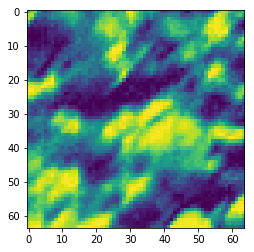

In [26]:
plt.imshow(XS[2,:,:,0])
YS[2]

Train model

In [27]:
checkpoint_cb = ModelCheckpoint(os.path.join(save_path,str(save_name)+'weights_VAE.{epoch:02d}-{val_loss:.2f}.hdf5'),save_best_only=True)
tb_callback = TensorBoard()
callbacks = [EarlyStopping(monitor='val_loss', patience=patience, verbose=0),tb_callback, checkpoint_cb]

In [28]:
history = model.fit(x=XS_tr,y=[XS_tr,YS_scaled_tr],
                    epochs=100,batch_size=batch_size, validation_data=(XS_val,[XS_val,YS_scaled_val]),callbacks=callbacks)

Train on 11020 samples, validate on 4724 samples
Epoch 1/100
11020/11020 [==============================] - 9s 823us/step - loss: 4673.8158 - model_2_loss: 3016.5708 - predictor_loss: 0.1657 - val_loss: 4049.0835 - val_model_2_loss: 2839.9717 - val_predictor_loss: 0.1209
Epoch 2/100
11020/11020 [==============================] - 5s 490us/step - loss: 4034.6853 - model_2_loss: 2904.9502 - predictor_loss: 0.1130 - val_loss: 3943.4465 - val_model_2_loss: 2806.1329 - val_predictor_loss: 0.1137
Epoch 3/100
11020/11020 [==============================] - 6s 502us/step - loss: 3937.6515 - model_2_loss: 2848.0283 - predictor_loss: 0.1090 - val_loss: 3961.7793 - val_model_2_loss: 2842.2917 - val_predictor_loss: 0.1119
Epoch 4/100
11020/11020 [==============================] - 5s 491us/step - loss: 3838.2324 - model_2_loss: 2797.7937 - predictor_loss: 0.1040 - val_loss: 5876.7902 - val_model_2_loss: 3546.7860 - val_predictor_loss: 0.2330
Epoch 5/100
11020/11020 [==============================] - 

plt.figure(figsize=(6, 6))  
plot_train_history_loss(history)


### load trained model weights

In [30]:
model.load_weights(r'...hdf5')

## Visualize latent space

In [31]:
 %matplotlib inline

In [32]:
num_pred = 4000

### encode validation set

In [33]:
en_mean_test, en_var_test = encoder.predict(XS_val)

reduce latent space dimensionality by kernel PCA

In [57]:
gamma = round(1/90,4)
transformer = KernelPCA(n_components=2, kernel='rbf',random_state = 4,gamma=gamma)
transformer = transformer.fit(en_mean_test)
XS_val_kpca = transformer.transform(en_mean_test)


In [58]:
plt.rcParams.update({'font.size': 28,'xtick.major.width' : 2,'xtick.minor.width' : 2,'ytick.major.width' : 2,'axes.linewidth':2})

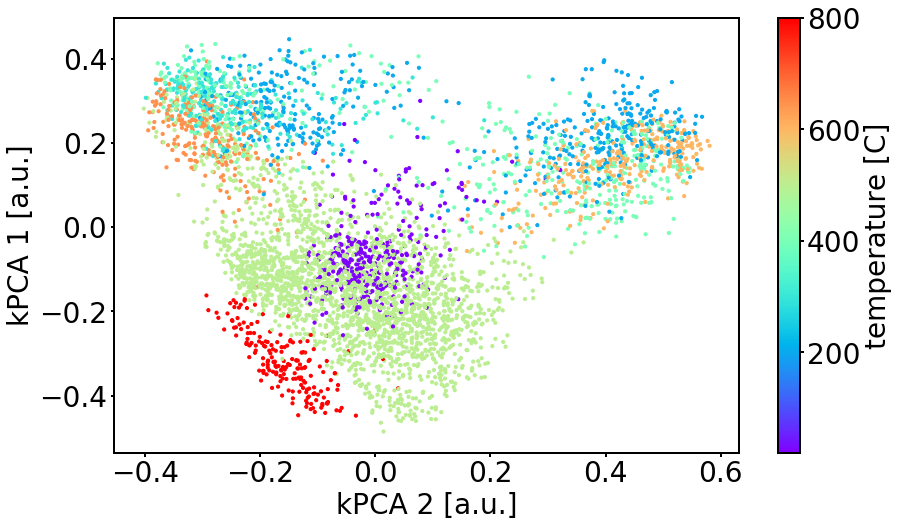

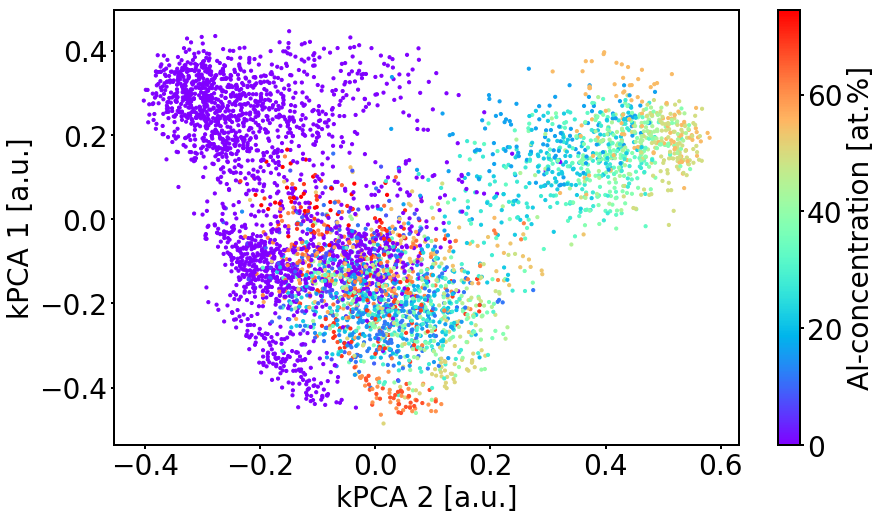

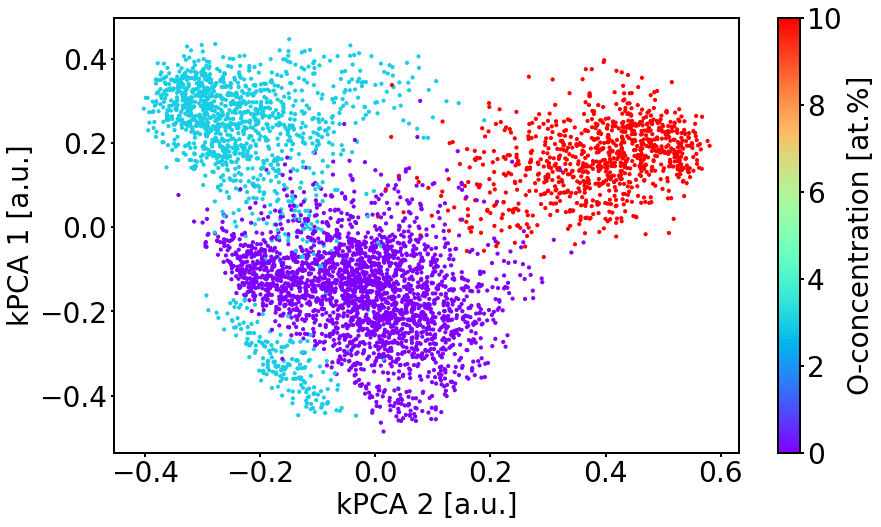

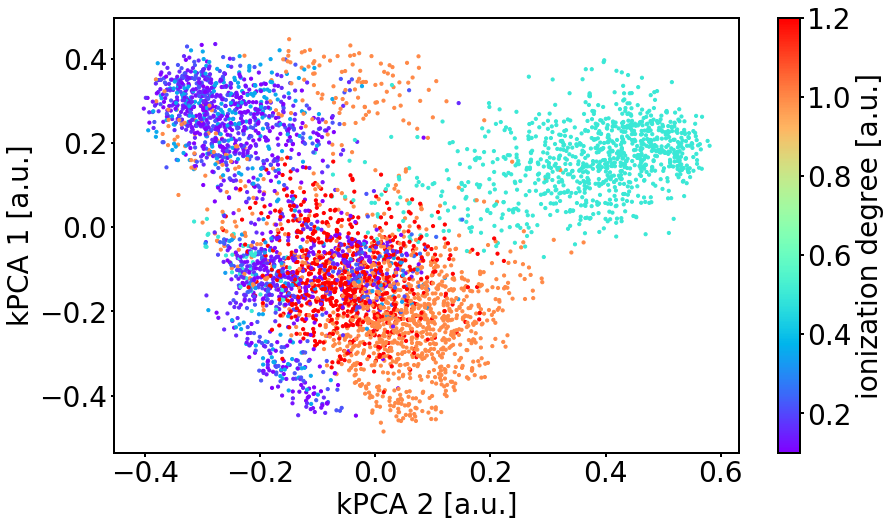

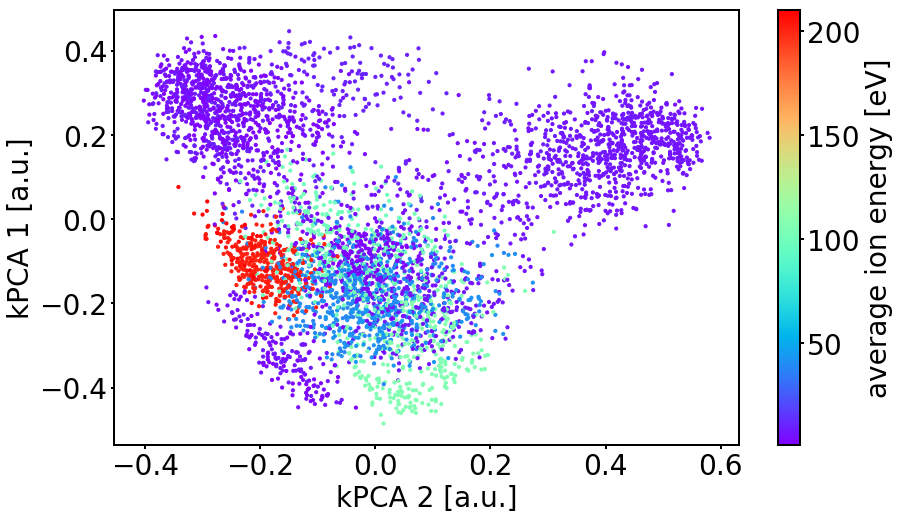

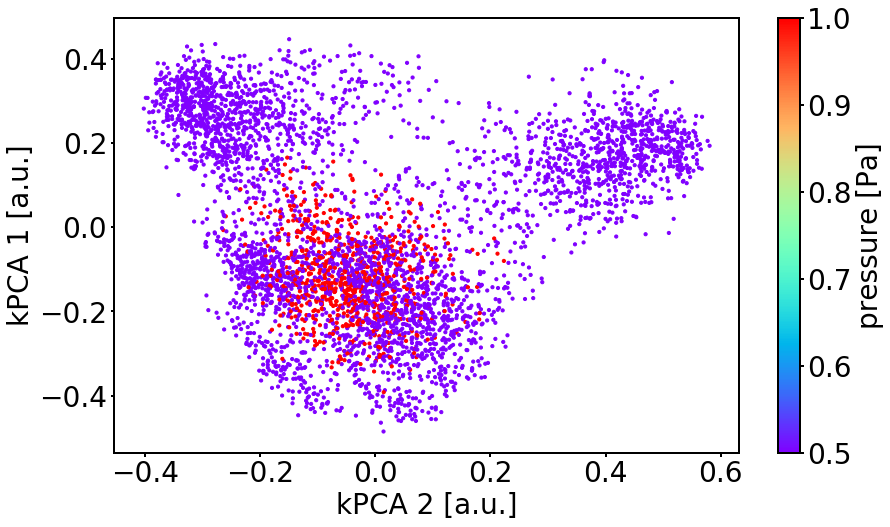

In [59]:
c=scaler.inverse_transform(YS_scaled_val)
for i in range(6):
    plt.figure(figsize=(14, 8))
    sc = plt.scatter(XS_val_kpca[:,0],XS_val_kpca[:,1],c=c[:,i],s=10,cmap='rainbow')
    plt.ylabel('kPCA 1 [a.u.]')
    plt.xlabel('kPCA 2 [a.u.]')
    cbar = plt.colorbar(sc)
    cbar.set_label(str(Y_COLUMNS[i]))




### decode images from latent space

In [37]:
decoded = decoder.predict(en_mean_test)

### plot original and predicted images

<Figure size 432x288 with 0 Axes>

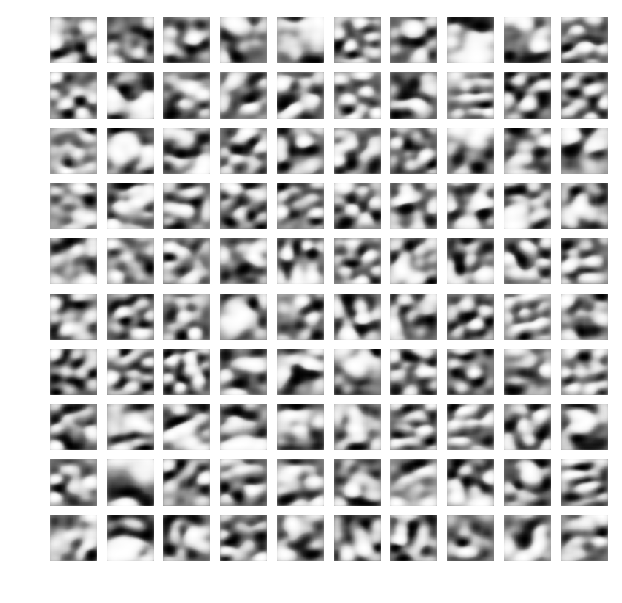

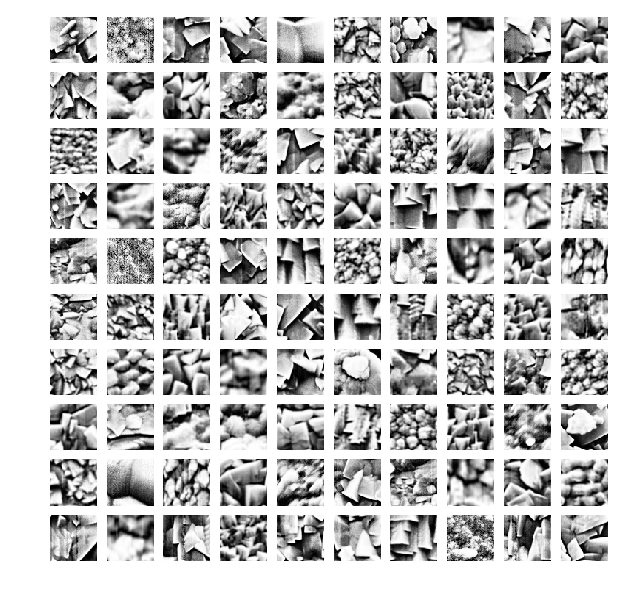

In [38]:
plt.gray()
fig = plt.figure(figsize=(10, 10))
for i in range(100):
    a=fig.add_subplot(10,10,i+1)

    image = decoded[i].reshape(img_rows, img_cols)
    imshow(image,cmap='Greys_r')
    axis('off')

#
fig = plt.figure(figsize=(10, 10))
#plt.figure(figsize=(10, 10))
j=1
for i in range(100):
    a=fig.add_subplot(10,10,i+1)
    
    digit = XS_val[i].reshape(plen, plen)
    
    imshow(digit,cmap='Greys_r')
    axis('off')


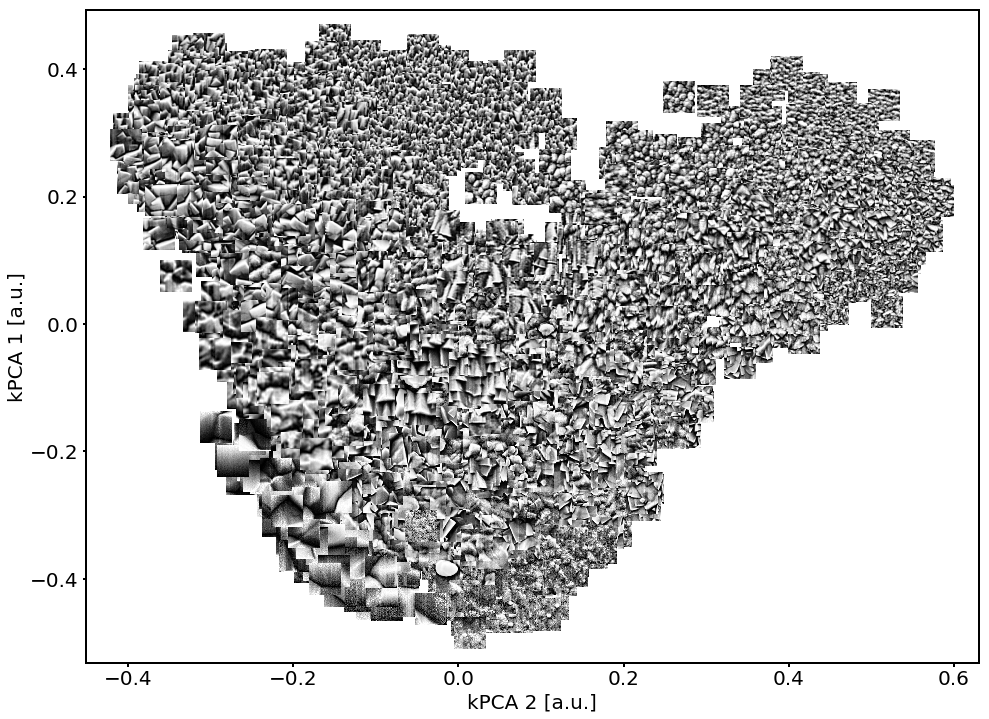

In [60]:
fig, ax = plt.subplots(figsize=(16, 12)) 
SZD_imscatter(XS_val_kpca[:,0],XS_val_kpca[:,1],ax,XS_val,0.5)
plt.ylabel('kPCA 1 [a.u.]',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('kPCA 2 [a.u.]',fontsize=20)


### Load classifier model

In [40]:
from keras.models import load_model


In [41]:
microstructure_model = load_model(r'D:\Sciebo\Literatur\eigene Veröffentlichungen\Autoencoding SZD\Review 1\GIT\04. Microstructure classifier weights\structure_classifier.h5')

In [42]:
colors = ['red','green','blue','light blue','light green']

In [43]:
pred = microstructure_model.predict((XS_val-0.5)*2)

In [44]:
labels_c = ['facetted', 'facetted-oriented', 'featureless', 'fine grained',
       'large facetted', 'smooth-facetted']

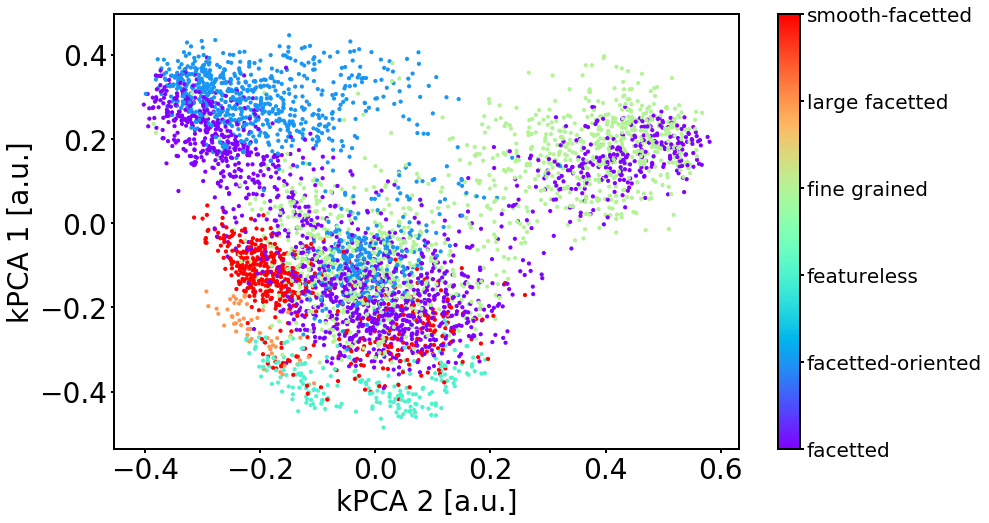

In [61]:
plt.style.use('seaborn-muted')
plt.figure(figsize=(14, 8))
sc = plt.scatter(XS_val_kpca[:,0],XS_val_kpca[:,1],c=np.argmax(pred,axis=1),s=10,cmap='rainbow')
plt.ylabel('kPCA 1 [a.u.]')
plt.xlabel('kPCA 2 [a.u.]')
cbar = plt.colorbar(sc, ticks=[0, 1, 2,3,4,5])
cbar.ax.set_yticklabels(labels_c,fontsize = 20) 
plt.show()

### Model to predict latent variables from conditinal parameters

In [46]:
# define base model
def baseline_model():
    # create model
    
    c_model = Sequential()
    c_model.add(Dense(6, input_dim=6, kernel_initializer='normal'))
    c_model.add(Dense(25, kernel_initializer='normal', activation='relu'))
    c_model.add(Dense(45, kernel_initializer='normal', activation='relu'))
    c_model.add(Dense(60, kernel_initializer='normal', activation='relu'))
   # 
    c_model.add(Dense(64, kernel_initializer='normal',activation='linear'))

    # Compile model
    c_model.compile(loss='mse', optimizer=adadelta, metrics=['mse','mae'])
    return c_model

In [47]:
c_model = baseline_model()

In [48]:
yy_train=encoder.predict(XS_tr)[0]
yy_test=encoder.predict(XS_val)[0]

In [49]:
callbacks = [EarlyStopping(monitor='val_loss', patience=patience, verbose=1)]

history_reg = c_model.fit(x=YS_scaled_tr, y=yy_train,
              epochs=150,
              shuffle=True,
              batch_size=100,
              validation_data=(YS_scaled_val,yy_test),
              verbose=1,validation_split=0.2,callbacks=callbacks)


Train on 11020 samples, validate on 4724 samples
Epoch 1/150
11020/11020 [==============================] - 1s 82us/step - loss: 0.9128 - mean_squared_error: 0.9128 - mean_absolute_error: 0.7524 - val_loss: 0.8630 - val_mean_squared_error: 0.8630 - val_mean_absolute_error: 0.7313
Epoch 2/150
11020/11020 [==============================] - 0s 35us/step - loss: 0.8780 - mean_squared_error: 0.8780 - mean_absolute_error: 0.7375 - val_loss: 0.8625 - val_mean_squared_error: 0.8625 - val_mean_absolute_error: 0.7310
Epoch 3/150
11020/11020 [==============================] - 0s 35us/step - loss: 0.8773 - mean_squared_error: 0.8773 - mean_absolute_error: 0.7372 - val_loss: 0.8607 - val_mean_squared_error: 0.8607 - val_mean_absolute_error: 0.7303
Epoch 4/150
11020/11020 [==============================] - 0s 35us/step - loss: 0.8686 - mean_squared_error: 0.8686 - mean_absolute_error: 0.7337 - val_loss: 0.8420 - val_mean_squared_error: 0.8420 - val_mean_absolute_error: 0.7222
Epoch 5/150
11020/11020

Epoch 36/150
11020/11020 [==============================] - 0s 38us/step - loss: 0.5756 - mean_squared_error: 0.5756 - mean_absolute_error: 0.5961 - val_loss: 0.5841 - val_mean_squared_error: 0.5841 - val_mean_absolute_error: 0.6003
Epoch 37/150
11020/11020 [==============================] - 0s 36us/step - loss: 0.5746 - mean_squared_error: 0.5746 - mean_absolute_error: 0.5956 - val_loss: 0.5823 - val_mean_squared_error: 0.5823 - val_mean_absolute_error: 0.5992
Epoch 38/150
11020/11020 [==============================] - 0s 38us/step - loss: 0.5736 - mean_squared_error: 0.5736 - mean_absolute_error: 0.5950 - val_loss: 0.5917 - val_mean_squared_error: 0.5917 - val_mean_absolute_error: 0.6040
Epoch 39/150
11020/11020 [==============================] - 0s 36us/step - loss: 0.5723 - mean_squared_error: 0.5723 - mean_absolute_error: 0.5943 - val_loss: 0.5821 - val_mean_squared_error: 0.5821 - val_mean_absolute_error: 0.5988
Epoch 40/150
11020/11020 [==============================] - 0s 38us/

In [50]:
c_model.evaluate(YS_scaled_val,yy_test)

4724/4724 [==============================] - 0s 28us/step


[0.5673842383682677, 0.5673842383682677, 0.5905788140615904]

### Generate images from conditional parameters

In [51]:
decoded = decoder.predict(c_model.predict(YS_scaled_val))

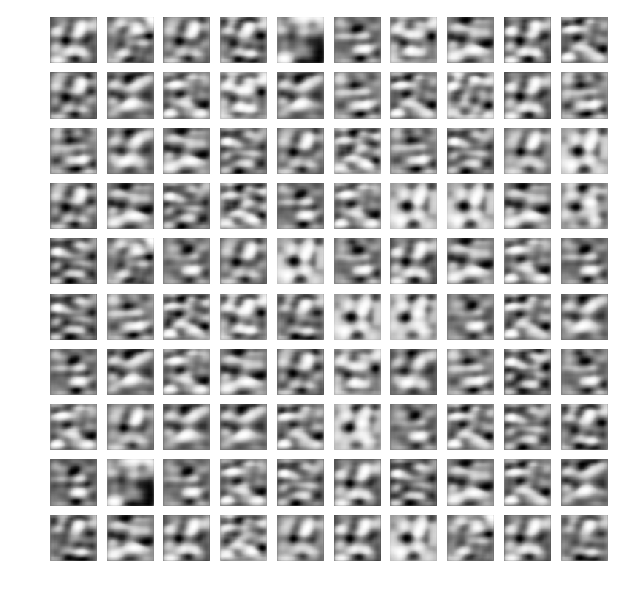

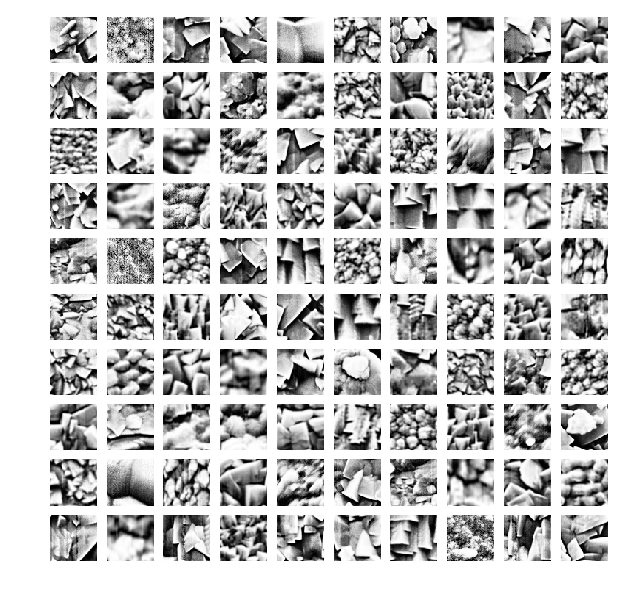

In [52]:
fig = plt.figure(figsize=(10, 10))
for i in range(100):
    a=fig.add_subplot(10,10,i+1)
    image = decoded[i].reshape(img_rows, img_cols)
    imshow(image,cmap='Greys_r')
    axis('off')
plt.savefig(str(save_name)+'predction'  + '.png',dpi=150)

#
fig = plt.figure(figsize=(10, 10))
j=1
for i in range(100):
    a=fig.add_subplot(10,10,i+1)
    digit = XS_val[i].reshape(plen, plen)
    imshow(digit,cmap='Greys_r')
    axis('off')
plt.savefig(str(save_name)+'patches_val_original_compare_prediction'  + '.png',dpi=150)

### Generate SZD

Text(0.5, 0, 'deposition temperature [°C]')

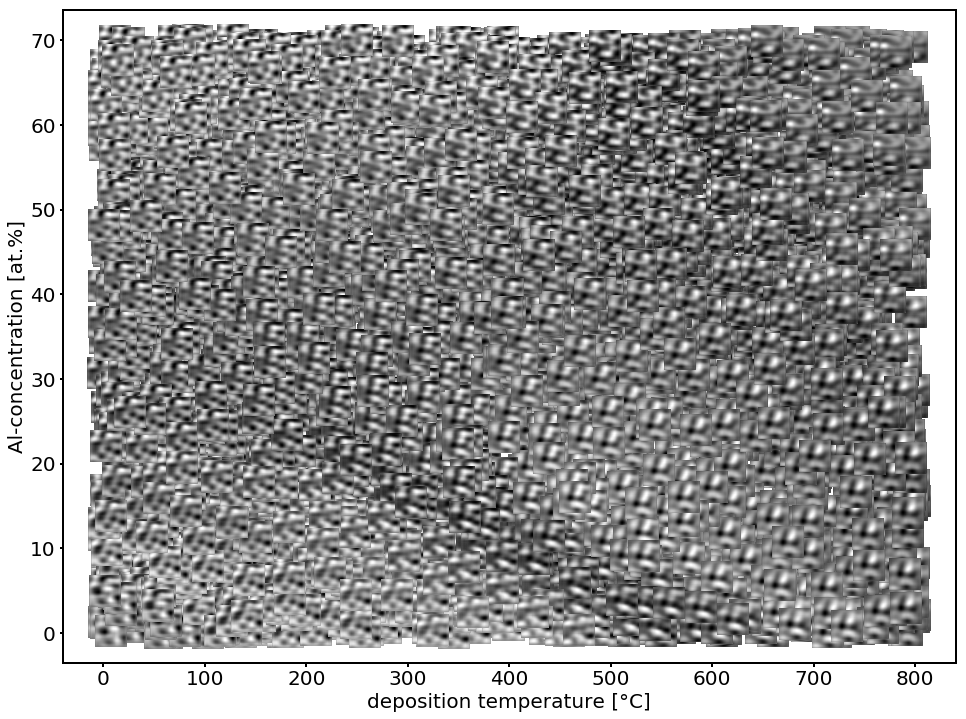

In [53]:
add_ = [0,0,1.0,1.0,7,0.5]
pp = create_randuni_process_vector(num_pred,[2,3,4,5],add_)
z_pred = c_model.predict(pp)
pp=scaler.inverse_transform(pp)

decoded = decoder.predict(z_pred) 
#pr_inv_trans=p_scaler.inverse_transform(z_pred[:,100:])
fig, ax = plt.subplots(figsize=(16, 12))
gSZD_imscatter(pp[:,0],pp[:,1],decoded,ax,0.5)
plt.ylabel('Al-concentration [at.%]',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('deposition temperature [°C]',fontsize=20)
